### 유사 문제 추천 (입력 때마다 달라짐)
- find_similar_sentences 함수에 문제 제목을 입력하면 유사 문제가 추천됨
    - Sentence Bert 모델을 사용해 문제의 문장 간 유사도를 구하고, 코사인 유사도를 사용해 문제 간 알고리즘 분류 유사도를 구하여 유사도가 높은 순으로 정렬
    - 최종 유사도: 문장 간 유사도 + 알고리즘 분류 유사도
    - 현재 선택한 문제의 레벨과 3 이내로 차이나는 항목만 추천되도록 함
- **유사도뿐만 아니라 난이도별로 정렬할 수 있게 함**
- **반복문 조건문 같이 유사하지 않은 문제가 추천되면 어떡하지? (사용자 피드백: 사용자에게 문제별로 유사 문제가 맞는지 추천을 받음 -> 추천 순으로 정렬?)**

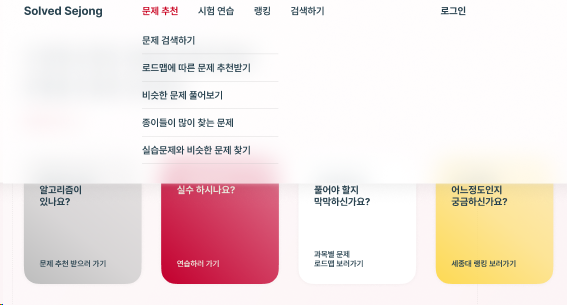

- **로드맵에 따른 문제 추천받기, 비슷한 문제 풀어보기만 & 문제 제목을 검색하게끔**

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 문제 데이터프레임 불러오기
df = pd.read_csv('df_최종_최종.csv')

# null값 처리
df.loc[df['분류'].isnull(), '분류'] = '0'

# 문장 리스트
sentences = df['분류'].tolist()

# TF-IDF 벡터화
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)

# 코사인 유사도 계산
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [2]:
# sentence-bert 문장 유사도 행렬 불러오기
import pickle
with open('similarities_sb.pkl', 'rb') as f:
    similarities_sb = pickle.load(f)

In [3]:
# 최종 유사도, sentence-bert 문장 유사도 행렬과 분류 코사인 유사도 행렬을 더함
combined_matrix = similarities_sb + cosine_sim

In [4]:
def find_similar_sentences(title, top_n=5):
    title_data = df[df['제목'] == title]
    title_index = title_data.index.values[0]

    # 해당 작품과 다른 작품 간의 유사도
    title_similarity_scores = combined_matrix[title_index]

    # 유사도가 높은 상위 N개 인덱스를 찾음
    similar_indexes = np.argsort(title_similarity_scores)[::-1][:top_n]

    # 유사도 값 가져오기
    similar_cosine_values = [title_similarity_scores[i] for i in similar_indexes]

    # 유사한 작품 데이터 프레임 생성
    similar_titles = df.iloc[similar_indexes]

    # "유사도" 열 추가
    similar_titles['유사도'] = similar_cosine_values

    # 현재 선택한 제목(title)의 인덱스(title_index)가 유사한 제목들의 리스트(similar_indexes) 안에 있는지 확인
    if title_index in similar_indexes:
        # 현재 선택한 제목을 유사한 제목들의 데이터프레임(similar_titles)에서 제외
        similar_titles = similar_titles[similar_titles.index != title_index]
        # 현재 선택한 제목의 데이터를 원본 데이터프레임(df)에서 가져와 title_row에 저장
        title_row = df.loc[title_index]
        title_row['유사도'] = '기준'
        similar_titles = pd.concat([pd.DataFrame([title_row]), similar_titles])

    # 현재 선택한 제목(title)의 레벨(level)을 가져옴
    title_level = title_data['level'].values[0]
    
    # 레벨이 현재 선택한 제목(title)의 레벨과 3 이내로 차이나는 항목만 필터링
    similar_titles = similar_titles[abs(similar_titles['level'] - title_level) <= 3]

    return similar_titles[['내용링크', '제목', '문제', 'level', '분류', '유사도']]

In [5]:
find_similar_sentences('N과 M (1)',top_n=20)

,내용링크,제목,문제,level,분류,유사도
5128,/problem/15649,N과 M (1),"자연수 N과 M이 주어졌을 때, 아래 조건을 만족하는 길이가 M인 수열을 모두 구하...",8.0,"백트래킹,",기준
5129,/problem/15650,N과 M (2),"자연수 N과 M이 주어졌을 때, 아래 조건을 만족하는 길이가 M인 수열을 모두 구하...",8.0,"백트래킹,",2.0
5131,/problem/15652,N과 M (4),"자연수 N과 M이 주어졌을 때, 아래 조건을 만족하는 길이가 M인 수열을 모두 구하...",8.0,"백트래킹,",2.0
5130,/problem/15651,N과 M (3),"자연수 N과 M이 주어졌을 때, 아래 조건을 만족하는 길이가 M인 수열을 모두 구하...",8.0,"백트래킹,",2.0
5145,/problem/15666,N과 M (12),"N개의 자연수와 자연수 M이 주어졌을 때, 아래 조건을 만족하는 길이가 M인 수열을...",9.0,"백트래킹,",1.930854
5136,/problem/15657,N과 M (8),"N개의 자연수와 자연수 M이 주어졌을 때, 아래 조건을 만족하는 길이가 M인 수열을...",8.0,"백트래킹,",1.930854
5135,/problem/15656,N과 M (7),"N개의 자연수와 자연수 M이 주어졌을 때, 아래 조건을 만족하는 길이가 M인 수열을...",8.0,"백트래킹,",1.930854
5134,/problem/15655,N과 M (6),"N개의 자연수와 자연수 M이 주어졌을 때, 아래 조건을 만족하는 길이가 M인 수열을...",8.0,"백트래킹,",1.930854
5133,/problem/15654,N과 M (5),"N개의 자연수와 자연수 M이 주어졌을 때, 아래 조건을 만족하는 길이가 M인 수열을...",8.0,"백트래킹,",1.930854
5144,/problem/15665,N과 M (11),"N개의 자연수와 자연수 M이 주어졌을 때, 아래 조건을 만족하는 길이가 M인 수열을...",9.0,"백트래킹,",1.930854
